# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
import PIL.Image as Image
import yaml

## Configurations

In [3]:
class skinConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "skin"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1
    
config = skinConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class SkinDataset(utils.Dataset):
    def load_info(self):
        self.add_class("skin", 1, "closedcomedo")
        self.add_class("skin", 2, "opencomedo")
        self.add_class("skin", 3, "papule")
        self.add_class("skin", 4, "nudule")
        self.add_class("skin", 5, "scar")
        self.add_class("skin", 6, "undefined")
        
        data_dir_list = []
        for name in os.listdir(dataset_dir):
            path = os.path.join(dataset_dir, name)
            if os.path.isdir(path):
                data_dir_list.append(path)
        
        for i, data_dir in enumerate(data_dir_list):
            self.add_image("skin", image_id=i, path=data_dir)
            
    def load_image(self, image_id):
        info = self.image_info[image_id]
        img_path = os.path.join(info['path'], img_file)
        image = np.asarray(Image.open(img_path))
        return image
    
    def draw_mask(self, mask, mask_flat):
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                pixel = mask_flat[i, j]
                if pixel > 0:
                    mask[i, j, pixel - 1] = 1
        return mask
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        
        mask_path = os.path.join(info['path'], mask_file)
        mask_flat = np.asarray(Image.open(mask_path))
        instance_num = np.max(mask_flat)
        mask = np.zeros([mask_flat.shape[0], mask_flat.shape[1], instance_num], dtype=np.uint8)
        mask = self.draw_mask(mask, mask_flat)
        '''
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(instance_num - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        ''' 
        instance_name_path = os.path.join(info['path'], instance_name_file)
        with open(instance_name_path, encoding='utf-8') as file:
            instance_name_list = file.readlines()
        instance_name_list = [instance_name.strip('\n') for instance_name in instance_name_list]
        del instance_name_list[0]        
        class_ids = np.array([self.class_names.index(s) for s in instance_name_list])
        
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [6]:
img_file = 'img.png'
mask_file = 'mask.png'
instance_name_file = 'instance_name.txt'

dataset_dir = './facedata'

dataset_train = SkinDataset()
dataset_train.load_info()
dataset_train.prepare()

dataset_val = SkinDataset()
dataset_val.load_info()
dataset_val.prepare()

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\47576\Desktop\Mask_RCNN\logs\skin20210111T2326\mask_rcnn_skin_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

C:\Users\47576\anaconda3\envs\test\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
10/10 [==============================] - 435s 43s/step - loss: 6.0481 - rpn_class_loss: 2.5759 - rpn_bbox_loss: 2.0133 - mrcnn_class_loss: 0.7831 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.2296 - val_loss: 2.5316 - val_rpn_class_loss: 0.6971 - val_rpn_bbox_loss: 1.8344 - val_mrcnn_class_loss: 2.0742e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 2/30
10/10 [==============================] - 315s 31s/step - loss: 3.5906 - rpn_class_loss: 1.0085 - rpn_bbox_loss: 1.3328 - mrcnn_class_loss: 0.3198 - mrcnn_bbox_loss: 0.4453 - mrcnn_mask_loss: 0.4843 - val_loss: 3.4771 - val_rpn_class_loss: 0.5974 - val_rpn_bbox_loss: 1.0743 - val_mrcnn_class_loss: 0.2258 - val_mrcnn_bbox_loss: 0.9512 - val_mrcnn_mask_loss: 0.6284
Epoch 3/30
10/10 [==============================] - 322s 32s/step - loss: 3.4247 - rpn_class_loss: 0.4978 - rpn_bbox_loss: 1.2517 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.8576 - mrcnn_mask_loss: 0.5751 - val_loss: 3.9070 - val_rp

Epoch 23/30
10/10 [==============================] - 327s 33s/step - loss: 2.9446 - rpn_class_loss: 0.3526 - rpn_bbox_loss: 1.1148 - mrcnn_class_loss: 0.3953 - mrcnn_bbox_loss: 0.5563 - mrcnn_mask_loss: 0.5254 - val_loss: 3.4641 - val_rpn_class_loss: 0.3351 - val_rpn_bbox_loss: 1.1345 - val_mrcnn_class_loss: 0.7911 - val_mrcnn_bbox_loss: 0.6057 - val_mrcnn_mask_loss: 0.5977
Epoch 24/30
10/10 [==============================] - 323s 32s/step - loss: 2.8929 - rpn_class_loss: 0.3233 - rpn_bbox_loss: 1.0631 - mrcnn_class_loss: 0.4596 - mrcnn_bbox_loss: 0.5093 - mrcnn_mask_loss: 0.5376 - val_loss: 3.2612 - val_rpn_class_loss: 0.2635 - val_rpn_bbox_loss: 1.3072 - val_mrcnn_class_loss: 0.4585 - val_mrcnn_bbox_loss: 0.6469 - val_mrcnn_mask_loss: 0.5851
Epoch 25/30
10/10 [==============================] - 317s 32s/step - loss: 2.7787 - rpn_class_loss: 0.2918 - rpn_bbox_loss: 0.9886 - mrcnn_class_loss: 0.4703 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4882 - val_loss: 2.7506 - val_rpn_class_l

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(skinConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


# model_path = model.find_last()
model_path = r'C:\Users\47576\Desktop\Mask_RCNN\logs\skin20210111T2116\mask_rcnn_skin_0002.h5'

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\47576\Desktop\Mask_RCNN\logs\skin20210111T2116\mask_rcnn_skin_0002.h5
Re-starting from epoch 2


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max: 4600.00000  float64
gt_class_id              shape: (67,)                 min:    2.00000  max:    4.00000  int32
gt_bbox                  shape: (67, 4)               min:   45.00000  max:  486.00000  int32
gt_mask                  shape: (512, 512, 67)        min:    0.00000  max:    1.00000  bool


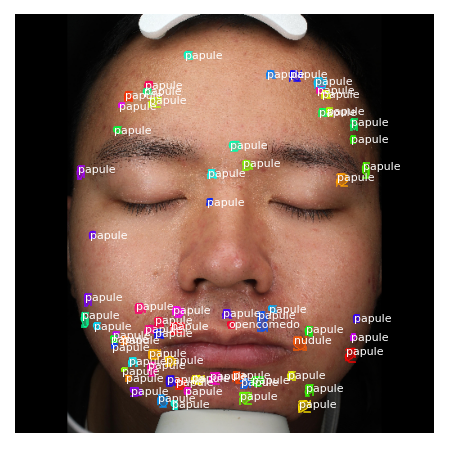

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


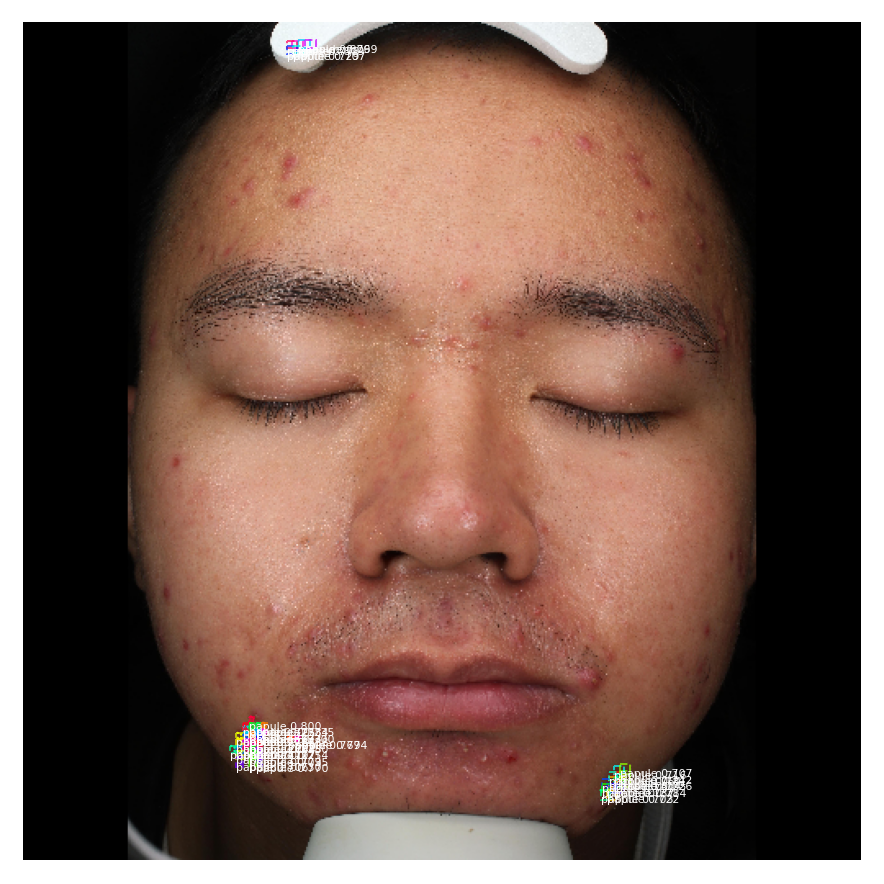

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
